In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import requests
from bs4 import BeautifulSoup
from IPython.display import Markdown, display
from copy import deepcopy as dc
import numba as nb
import itertools
import functools

In [2]:
url='https://www.janestreet.com/puzzles/travel-agent-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
y =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(y)])
display(Markdown("### "+y[7]+"\n\n"+str("\n".join(y[8:9]))))

### Travel Agent

February 2016 : Puzzle

<img src="https://www.janestreet.com/puzzles/feb16_puzzle.png" width="350" >

In [3]:
# abandon z3 and go back to brute force checking all possibilities .. which worked pretty well !
fixed = np.array([[1, 5, 4, 4, 6, 1, 1, 4, 1, 3, 7, 5],
                  [3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
                  [4, 0, 6, 4, 1, 8, 1, 4, 2, 1, 0, 3],
                  [7, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 2],
                  [1, 0, 1, 0, 6, 1, 6, 2, 0, 2, 0, 1],
                  [8, 0, 4, 0, 1, 0, 0, 8, 0, 3, 0, 5],
                  [4, 0, 2, 0, 5, 0, 0, 3, 0, 5, 0, 2],
                  [8, 0, 5, 0, 1, 1, 2, 3, 0, 4, 0, 6],
                  [6, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 6],
                  [3, 0, 6, 3, 6, 5, 4, 3, 4, 5, 0, 1],
                  [6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3],
                  [2, 1, 6, 6, 4, 5, 2, 1, 1, 1, 7, 1]])

In [4]:
def grid_print(grid,orig_grid,path):
    n = len(grid)/4
    fig,ax = plt.subplots(1,1,figsize=(n,n))    
    text = np.array(grid).astype('int').astype('str')
    text[text=="0"] = ""   
    ax =sns.heatmap(orig_grid,annot=text,cbar=False
                    ,cmap=ListedColormap(["w","r","yellow","green","orange","c","m","brown","grey","hotpink"]
                    ,N=np.max(grid)),fmt=""
                    ,linewidths=2,linecolor="k",annot_kws={"size":10,"color":"k"},alpha=.2,vmin=0)
    ax.tick_params(left=False, bottom=False,labelleft=False, labelright=True)
    xpoints = [i //len(grid)+0.5 for i in path]
    ypoints = [i % len(grid)+0.5 for i in path]
    plt.plot(xpoints,ypoints,"r")
    plt.axis("off")
    plt.tight_layout()
    plt.show()   

In [5]:
@functools.lru_cache(maxsize=None)
def roll(die1,die2,die3,die4,die5,die6,i,j):
    #['bot','frt','lft','rgt','bak','top']
    u = [5,1,3,4,6,2]
    d = [2,6,3,4,1,5]
    l = [3,2,6,1,5,4] 
    r = [4,2,1,6,5,3]
    die = [die1,die2,die3,die4,die5,die6]
    if i==-1 and j==0:
        return [die[i-1] for i in u]
    elif i == 1 and j==0:
        return [die[i-1] for i in d]
    elif i == 0 and j==1:
        return [die[i-1] for i in l]
    elif i == 0 and j==-1:
        return [die[i-1] for i in r]
    
@functools.lru_cache(maxsize=None)
def neighbours(i,j,N):
    return [[i+x,j+y] for (x,y) in [(-1,0),(0,-1),(1,0),(0,1)] if i+x >= 0 and i+x < N and j+y >= 0 and j+y < N ]

In [6]:
def solve_grid(board,dice):
    N=board.shape[0]
    soln =[0,0]
    best_score = 0
    brd = np.array(board)
    brd[0,0] = -1
    paths = [[brd,dice,dice[0],0,0,2]] #board dice score,x,y,stp
    
    while len(paths) > 0:
        brd,d,s,x,y,step = paths.pop()
        if x == N-1 and y == N-1:
            if s > best_score:                
                soln = [brd,s]
                best_score = s
        else:
            for a,b in neighbours(x,y,N):
                new_d = roll(*d,a-x,b-y)                
                if (new_d[0] == brd[a,b]) or (brd[a,b] == 0):
                    new_b = np.array(brd)  
                    new_s = s * int(new_d[0])
                    new_b[a,b] = -step       
                    paths.append([new_b,new_d,new_s,a,b,step+1])          
    return soln

Loop through all possible dice
for die [1, 3, 2, 2, 2, 2] score is 1.369513e+16
for die [1, 3, 2, 2, 2, 3] score is 7.487812e+18
for die [1, 3, 2, 2, 2, 4] score is 5.385144e+21
for die [1, 3, 2, 2, 2, 5] score is 4.814694e+24
for die [1, 3, 2, 2, 3, 5] score is 1.665837e+26
for die [1, 3, 2, 2, 3, 6] score is 1.719071e+27
for die [1, 3, 2, 2, 5, 4] score is 6.419592e+27
for die [1, 3, 2, 2, 6, 5] score is 2.558726e+28
for die [1, 3, 2, 2, 6, 6] score is 3.911841e+29
for die [1, 3, 2, 2, 8, 5] score is 8.077717e+29
for die [1, 3, 2, 3, 5, 6] score is 3.073938e+33
for die [1, 3, 2, 4, 4, 6] score is 8.002415e+33
for die [1, 3, 2, 4, 5, 6] score is 2.384905e+35
for die [1, 3, 2, 4, 6, 6] score is 3.114852e+36
for die [1, 3, 2, 6, 6, 6] score is 2.020703e+38
for die [1, 3, 3, 8, 4, 6] score is 5.980516e+38
for die [1, 3, 3, 8, 6, 6] score is 1.551900e+41
for die [1, 3, 4, 8, 6, 6] score is 4.354879e+42
for die [1, 3, 6, 7, 6, 6] score is 1.264519e+43
for die [1, 3, 6, 8, 6, 6] score is 6.

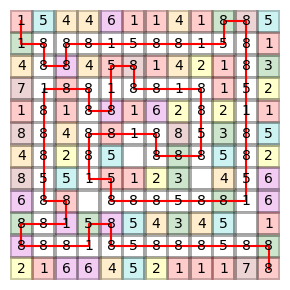

In [7]:
# define all possible dice given the starting square and first moves
dice = [[1,3,i,j,k,l] for i,j,k,l in itertools.product(range(2,9),repeat=4)] +\
       [[1,i,j,5,k,l] for i,j,k,l in itertools.product(range(2,9),repeat=4)]

start= time.time()
best = 0
print("Loop through all possible dice")
for die in dice:
    grid,score = solve_grid(fixed,die)
    if score > best:
        best=score
        best_die = die
        best_grid=grid
        print("for die {} score is {:e}".format(die,score))

print("Iteration took {:.2f} seconds".format(time.time()-start))

size = best_grid.shape[0]
path = [int(x+y*size) for x,y in [np.where(best_grid == n) for n in range(-1,np.min(best_grid)-1,-1)]]

best_show_grid = np.array(fixed)

for i in range(len(path)-1):
    x = path[i+1] % size
    y = path[i+1] // size
    a = path[i] % size
    b = path[i] // size   
    best_show_grid[x,y] = die[0]
    die = roll(*die,x-a,y-b)

grid_print(best_show_grid,fixed,path) 


In [8]:
url='https://www.janestreet.com/puzzles/travel-agent-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(x)])
display(Markdown("### "+x[8]+"\n\n"+"\n".join(x[10:13])))

### February 2016 : Solution

This month’s puzzle was, we thought, extremely challenging! We received a number
of different valid solutions. About half of these were equal to the highest
score we could find as well: about
3.35 X 10^48
. An illustration of that
solution is presented here. Congrats to everyone who managed to take a crack at
this month’s puzzle — we’ll be randomly picking a few submitters to receive Jane
Street t-shirts!


<img src="https://www.janestreet.com/puzzles/feb16_puzzle_solution_trimmed.png" width="400">


In [9]:
len([[1,i,j,5,k,l] for i,j,k,l in itertools.product(range(2,9),repeat=4) if 7 in (i,j,k) or 3 in (i,j,k)])

1526

In [10]:
import cProfile
cProfile.run('solve_grid(fixed,die)')

         9884 function calls in 0.014 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       46    0.000    0.000    0.000    0.000 <ipython-input-5-c353ae5bf824>:1(roll)
       14    0.000    0.000    0.000    0.000 <ipython-input-5-c353ae5bf824>:10(<listcomp>)
       10    0.000    0.000    0.000    0.000 <ipython-input-5-c353ae5bf824>:12(<listcomp>)
        9    0.000    0.000    0.000    0.000 <ipython-input-5-c353ae5bf824>:14(<listcomp>)
       13    0.000    0.000    0.000    0.000 <ipython-input-5-c353ae5bf824>:16(<listcomp>)
        1    0.012    0.012    0.014    0.014 <ipython-input-6-7a5484dd504b>:1(solve_grid)
        1    0.000    0.000    0.014    0.014 <string>:1(<module>)
        1    0.000    0.000    0.014    0.014 {built-in method builtins.exec}
     2448    0.000    0.000    0.000    0.000 {built-in method builtins.len}
     2447    0.001    0.000    0.001    0.000 {built-in method numpy.array}
     2446